In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List
from IPython.display import Video
from PIL import Image, ImageDraw, ImageFont

In [2]:
plt.rcParams['figure.figsize'] = (20, 6)

# Data

In [3]:
TRAIN_PATH = '../data/train.mp4'
TEST_PATH = '../data/test.mp4'

In [4]:
def load_labels(path: str) -> List:
    with open(path, 'r') as f:
        return [float(it.strip()) for it in f.readlines()]

In [5]:
y = load_labels('../data/train.txt')

df = pd.DataFrame({
    'index': range(len(y)),
    'y': y
})

In [6]:
df_train = pd.read_csv(f'../experiments/exp001/pred_train.csv')
df_valid = pd.read_csv(f'../experiments/exp001/pred_valid.csv')
df_test = pd.read_csv(f'../experiments/exp001/pred_test.csv')

df_train = df_train.sort_values('index').reset_index(drop=True)
df_valid = df_valid.sort_values('index').reset_index(drop=True)
df_test = df_test.sort_values('index').reset_index(drop=True)

# Model objective error

In [7]:
N_TRAIN = 18360
y_train = df['y'].iloc[:N_TRAIN].values
y_valid = df['y'].iloc[N_TRAIN:].values

y_train = (y_train[:-1] + y_train[1:]) / 2.0
y_valid = (y_valid[:-1] + y_valid[1:]) / 2.0

y_train_pred = df_train['y_preds'].values
y_valid_pred = df_valid['y_preds'].values

train_mse = np.mean((y_train_pred - y_train) ** 2) 
valid_mse = np.mean((y_valid_pred - y_valid) ** 2) 

print(f'Train mse: {train_mse:.3f}')
print(f'Valid mse: {valid_mse:.3f}')

Train mse: 0.514
Valid mse: 2.439


# Real error

In [8]:
def plot(target: np.array, pred: np.array, title: str):
    plt.title(title)
    plt.ylabel('speed')
    plt.xlabel('frame')
    plt.plot(target, label='target')
    plt.plot(pred, label='prediction')
    plt.legend()

In [9]:
def smooth(values: np.array, n: int = 10) -> np.array:
    total = 0.0
    output = np.zeros_like(values)

    for i in range(len(values)):
        total += values[i]
        
        if i >= n:
            total -= values[i - n]
            
        output[i] = total / min(i + 1, n)
    
    return output

In [10]:
y_train = df['y'].iloc[:N_TRAIN].values
y_valid = df['y'].iloc[N_TRAIN:].values

In [11]:
y_train_pred = df_train['y_preds'].values
y_valid_pred = df_valid['y_preds'].values
y_test_pred = df_test['y_preds'].values

# Dump reconstruction
y_train_pred = np.concatenate([y_train_pred[:1], y_train_pred])
y_valid_pred = np.concatenate([y_valid_pred[:1], y_valid_pred])
y_test_pred = np.concatenate([y_test_pred[:1], y_test_pred])

# Smoothing (0.5 sec)
y_train_pred = smooth(y_train_pred)
y_valid_pred = smooth(y_valid_pred)
y_test_pred = smooth(y_test_pred)

train_mse = np.mean((y_train_pred - y_train) ** 2) 
valid_mse = np.mean((y_valid_pred - y_valid) ** 2) 

print(f'Train mse: {train_mse:.3f}')
print(f'Valid mse: {valid_mse:.3f}')

Train mse: 0.369
Valid mse: 2.176


In [12]:
with open('../experiments/exp001/test.txt', 'w') as f:
    for y in y_test_pred:
        f.write(f'{y}\n')

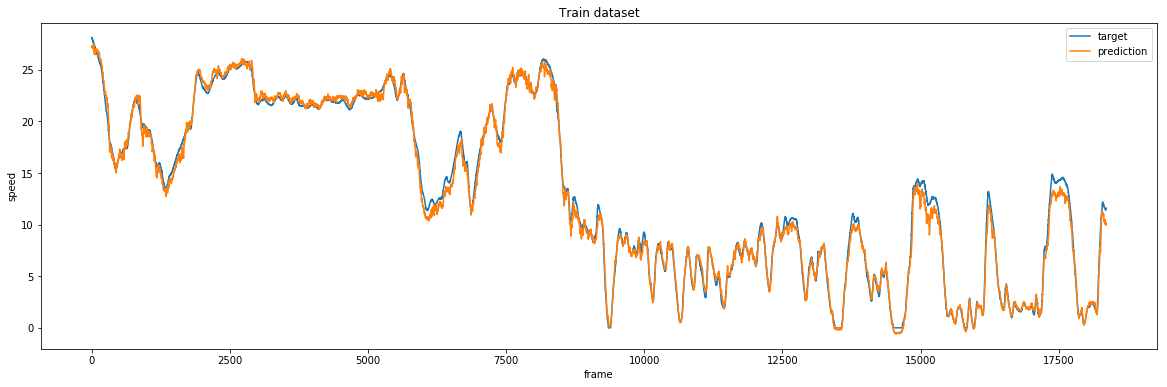

In [13]:
plot(y_train, y_train_pred, 'Train dataset')

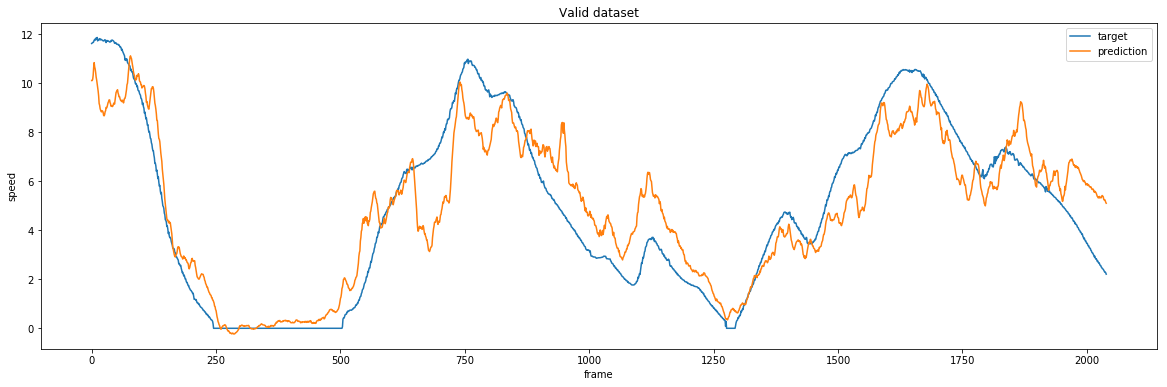

In [14]:
plot(y_valid, y_valid_pred, 'Valid dataset')

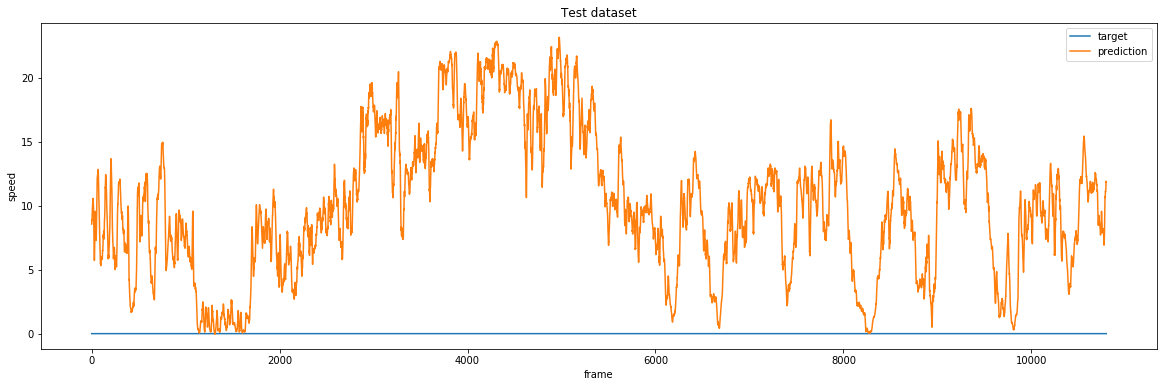

In [15]:
plot(np.zeros_like(y_test_pred), y_test_pred, 'Test dataset')

# Videos

In [16]:
def video_to_images(path: str) -> np.array:
    images = []
    video = cv2.VideoCapture(path)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    for index in tqdm(range(frame_count), desc='Converting video'):
        _, image = video.read()
        images.append(image)
    
    return images

In [17]:
def make_video(images: np.array, target: np.array, pred: np.array, output: str):
    font = ImageFont.truetype('unispace_bd.ttf', 20)
    data = zip(images, target, pred)
    
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output, fourcc, 20, (640, 480))
    
    for image, y, y_pred in tqdm(data, total=len(images), desc='Generating video'):
        image = Image.fromarray(image)
        draw = ImageDraw.Draw(image)
        
        draw.text((450, 470 - 80), f'pred:   {y_pred:.3f}', (14, 120, 255), font=font)
        
        if y is not None:
            draw.text((450, 470 - 110), f'target: {y:.3f}', (180, 119, 31), font=font)
            draw.text((450, 470 - 50), f'error:  {y - y_pred:.3f}', (0, 0, 255), font=font)
        
        out.write(np.array(image))
    
    out.release()

In [18]:
images = video_to_images(TRAIN_PATH)

Converting video: 100%|██████████| 20400/20400 [00:29<00:00, 699.44it/s]


In [19]:
images_train = images[:N_TRAIN]
images_valid = images[N_TRAIN:]

In [20]:
images_test = video_to_images(TEST_PATH)

Converting video: 100%|██████████| 10798/10798 [00:15<00:00, 709.25it/s]


In [21]:
make_video(images_train, y_train, y_train_pred, output='../experiments/exp001/train_pred.mp4')

Generating video: 100%|██████████| 18360/18360 [02:07<00:00, 144.27it/s]


In [22]:
make_video(images_valid, y_valid, y_valid_pred, output='../experiments/exp001/valid_pred.mp4')

Generating video: 100%|██████████| 2040/2040 [00:14<00:00, 143.52it/s]


In [23]:
make_video(images_test, [None] * len(images_test), y_test_pred, output='../experiments/exp001/test_pred.mp4')

Generating video: 100%|██████████| 10798/10798 [00:49<00:00, 217.26it/s]
